# Lab 8 : Word Embeddings

## 1. CBOW Word2vec from scratch

Two task definitions for training Word2vec:
- **CBOW** - Continuous Bag of Words:
  - Predict the words by its surrounding context
  - Neural networks __ probabilistic models -> are
- **Skip-gram**:
  - Predict surrounding context by the given word
  - money -> Banks make __ out of air.

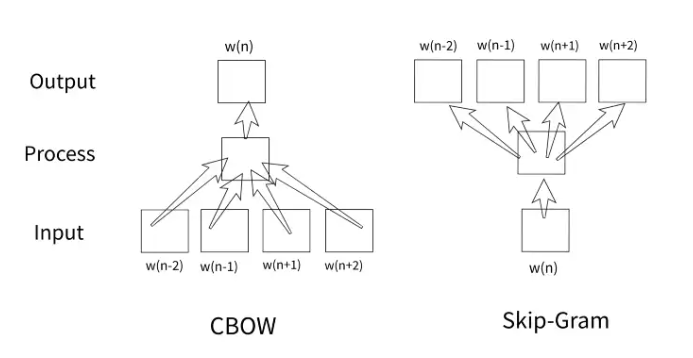

In [1]:
!pip install torchtext


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install 'portalocker>=2.0.0'


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from torchtext.datasets import WikiText103, WikiText2


# data = WikiText2(split="train") 
# DATASET_SIZE = 36718

data = WikiText103(split="train")
DATASET_SIZE = 1801350

for _, x in zip(range(5), data):
    print(x.strip())


= Valkyria Chronicles III =

Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " .
The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . Cha

In [3]:
import re
import unicodedata


def preprocess_sentence(s):
    s = s.strip()
    s = s.lower()
    s = re.sub(r"[^a-zA-Z.,!?]+", " ", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = s.strip()
    return s

In [4]:
for _, x in zip(range(5), data):
    print(preprocess_sentence(x))

/home/ivan/miniconda3/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "



valkyria chronicles iii

senj no valkyria unk chronicles japanese , lit . valkyria of the battlefield , commonly referred to as valkyria chronicles iii outside japan , is a tactical role playing video game developed by sega and media.vision for the playstation portable . released in january in japan , it is the third game in the valkyria series . employing the same fusion of tactical and real time gameplay as its predecessors , the story runs parallel to the first game and follows the nameless , a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit unk raven .
the game began development in , carrying over a large portion of the work done on valkyria chronicles ii . while it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . character designer unk honjou and composer hitoshi sakimoto bo

In [5]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")

def build_vocab(dataset):
    for text in dataset:
        yield tokenizer(preprocess_sentence(text))

vocab = build_vocab_from_iterator(build_vocab(data), max_tokens=10000, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])
VOCAB_SIZE = len(vocab)
len(vocab)

10000

In [6]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax


N_WORDS = 7
MAX_SEQUENCE_LENGTH = 128
EMBED_DIMENSION = 128
EMBED_MAX_NORM = 1


class CBOW_Model(nn.Module):
    def __init__(self):
        super(CBOW_Model, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIMENSION, max_norm=EMBED_MAX_NORM)
        self.linear = nn.Linear(EMBED_DIMENSION, VOCAB_SIZE)

    def forward(self, inputs):
        embeds = self.embedding(inputs)
        embeds_mean = torch.mean(embeds, dim=1)
        logits = self.linear(embeds_mean)
        output = softmax(logits, dim=1)
        return output

In [7]:
def text_pipeline(x): 
    return vocab(tokenizer(preprocess_sentence(x)))


def collate_cbow(batch):
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + N_WORDS * 2 + 1)]
            output = token_id_sequence.pop(N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

### What is the purpose of "collate_cbow" function?
Your answer:  

The collate_cbow function serves as a custom collate function for preparing batches of input and output data to train the CBOW model. Its main purpose is to generate context windows from the input text and create training examples for the CBOW model.

In [8]:
from functools import partial
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR


def train(model, data, epochs, batch_size, collate_fn, device):
    dataloader = DataLoader(data, batch_size=batch_size, 
                            shuffle=True, collate_fn=collate_fn)

    optimizer = Adam(model.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss()

    lr_lambda = lambda epoch: (epochs - epoch) / epochs
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

    model.train()
    model.to(device)

    for epoch in range(epochs):
        for i, batch_data in enumerate(tqdm(dataloader, total=DATASET_SIZE // batch_size + 1)):
            inputs = batch_data[0].to(device)
            labels = batch_data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        lr_scheduler.step()
        print(f"Epoch: {epoch + 1}/{epochs}, Train Loss={loss.item()}")

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cbow_model = CBOW_Model()
train(cbow_model, data, 1, 64, collate_cbow, device)

  0%|          | 0/28147 [00:00<?, ?it/s]

Epoch: 1/1, Train Loss=9.130722045898438


In [13]:
import numpy as np


embeddings = cbow_model.embedding.weight.cpu().detach().numpy()


def embed(word):
    return embeddings[vocab[word]]


result = embed("man") - embed("woman") + embed("girl")  # too small and not trained enough

scores = ((embeddings - result) ** 2).mean(axis=1)
scores = sorted(enumerate(scores), key=lambda x: x[1])[:5]
for i, score in scores:
  print(score, vocab.get_itos()[i])

0.00026597283 different
0.00026798027 distance
0.00031881622 windows
0.0003197831 attend
0.00036055665 roof


## 2. FastText

Library for sentence classification and learning of word representations 

### 2.1 Installing fastText

In [14]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 743.8 kB/s eta 0:00:001m799.5 kB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=306362 sha256=599d0b43f1a0911cc92a81ed0150a4db0fa64d0b5a3f49f07101f4ca47ba5c1e
  Stored in directory: /home/ivan/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


### 2.2 Training and testing a fastText model

In [15]:
## Download data, split the data to train and test
!wget https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz && tar xvzf cooking.stackexchange.tar.gz
!head -n 10000 cooking.stackexchange.txt > cooking.train
!tail -n 2000 cooking.stackexchange.txt > cooking.valid

--2023-03-25 11:04:28--  https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.222.236.115, 52.222.236.65, 52.222.236.117, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457609 (447K) [application/x-tar]
Saving to: ‘cooking.stackexchange.tar.gz’

cooking.stackexchan 100%[===================>] 446,88K  2,32MB/s    in 0,2s    

2023-03-25 11:04:28 (2,32 MB/s) - ‘cooking.stackexchange.tar.gz’ saved [457609/457609]

cooking.stackexchange.id
cooking.stackexchange.txt
readme.txt


#### Unsupervised Models

In [16]:
import fasttext

# Skipgram model :
model1 = fasttext.train_unsupervised('cooking.train', model='skipgram')

# cbow model :
model2 = fasttext.train_unsupervised('cooking.train', model='cbow')

Read 0M words
Number of words:  2017
Number of labels: 729
Progress: 100.0% words/sec/thread:  133043 lr:  0.000000 avg.loss:  2.812255 ETA:   0h 0m 0s
Read 0M words
Number of words:  2017
Number of labels: 729
Progress: 100.0% words/sec/thread:  199457 lr:  0.000000 avg.loss:  2.970448 ETA:   0h 0m 0s


#### Supervised Models

In [17]:
## training the model from zero
model_supervised = fasttext.train_supervised('cooking.train', dim=50)

Read 0M words
Number of words:  12746
Number of labels: 729
Progress: 100.0% words/sec/thread:   79961 lr:  0.000000 avg.loss: 10.288769 ETA:   0h 0m 0s


### Model perfomance

The model `predict(...)` method returns a tuple of (label, precision, recall). Precision @K can be retrieved by specifing the value of k in `test(...)` method

In [18]:
# print(model_supervised.labels)
pred = model_supervised.predict('Which tomatoes did you bake yesterday?', k=5)
print(pred)

model_supervised.test('cooking.valid', k=5)

(('__label__baking', '__label__food-safety', '__label__equipment', '__label__bread', '__label__substitutions'), array([0.04306332, 0.03730077, 0.02793224, 0.02312618, 0.02284599]))


(2000, 0.0642, 0.13848144952545297)

### 2.3 Loading a pretrained model <br>
Fasttext provides pre-trained word vectors for 157 languages, trained on Common Crawl and Wikipedia.

In [19]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
!unzip wiki-news-300d-1M-subword.vec.zip

--2023-03-25 11:04:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.222.236.115, 52.222.236.65, 52.222.236.117, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587879973 (561M) [application/zip]
Saving to: ‘wiki-news-300d-1M-subword.vec.zip’

wiki-news-300d-1M-s 100%[===================>] 560,65M  5,70MB/s    in 1m 55s  

2023-03-25 11:06:34 (4,89 MB/s) - ‘wiki-news-300d-1M-subword.vec.zip’ saved [587879973/587879973]

Archive:  wiki-news-300d-1M-subword.vec.zip
  inflating: wiki-news-300d-1M-subword.vec  


In [20]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        if tokens[0].lower() in ["king", "queen", "man", "woman", "moscow", "russia", "berlin", "germany", "girl", "boy"]:  # colab fails when loading whole vocabulary
            data[tokens[0]] = list(map(float, tokens[1:]))
    return data

embeddings = load_vectors("wiki-news-300d-1M-subword.vec")

In [21]:
embeddings.keys()

dict_keys(['man', 'Russia', 'Germany', 'woman', 'King', 'girl', 'Man', 'boy', 'king', 'Queen', 'Moscow', 'Berlin', 'Boy', 'Girl', 'queen', 'Woman', 'MAN', 'russia', 'MOSCOW', 'germany', 'BERLIN', 'KING', 'BOY', 'RUSSIA', 'WOMAN', 'GIRL', 'GERMANY', 'QUEEN', 'berlin', 'moscow', 'KIng', 'RUssia', 'WoMan', 'MoSCoW'])

In [23]:
import numpy as np

def embed(word):
    if word in embeddings:
        return np.array(embeddings[word])
    else:
        return None

def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

def print_5_closest(emb):
    # by euclidean distance
    distances = [(word, euclidean_distance(emb, np.array(embeddings[word]))) for word in embeddings]
    distances.sort(key=lambda x: x[1])

    print("5 closest words:")
    for i in range(5):
        print(f"{i + 1}. {distances[i][0]} ({distances[i][1]})")

result = embed("King") - embed("Man") + embed("woman")
print_5_closest(result)

5 closest words:
1. queen (0.6959301832799034)
2. king (0.7056775042468053)
3. woman (0.7274375230904715)
4. RUssia (0.7911593075986656)
5. King (0.7924917539003167)


In [24]:
result = embed("RUSSIA") - embed("MOSCOW") + embed("BERLIN")  # is not as accurate when lowercased, you can also try cosine similarity
print_5_closest(result)

5 closest words:
1. GERMANY (0.35989798554590435)
2. BERLIN (0.3856759261348834)
3. RUSSIA (0.3951481873930336)
4. Germany (0.481642741043608)
5. RUssia (0.494514367839803)


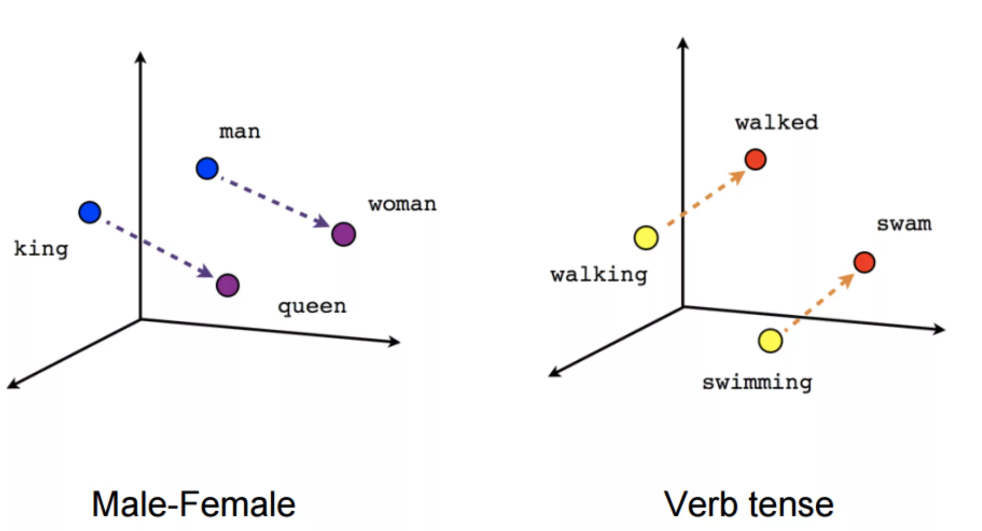

## References
1. [Word2vec by OlgaChernytska](https://github.com/OlgaChernytska/word2vec-pytorch/tree/main/utils)
1. [FastText: Under the Hood](https://towardsdatascience.com/fasttext-under-the-hood-11efc57b2b3)
1. [precision](https://en.wikipedia.org/wiki/Precision_and_recall#Precision)
1. [recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall)
1. [Bag of Tricks for Efficient Text Classification](https://arxiv.org/abs/1607.01759)